In [1]:
import pandas as pd

# 파일 경로
files = [
    f"뷰티푸드 별점.csv",
    f"소품도구 별점.csv",
    f"아모레크롤링_스킨케어_완료.csv",
    f"아모레크롤링_메이크업_완료.csv",
    f"향수 별점.csv"
]


df_list = []


for file in files:
    temp_df = pd.read_csv(file)
    df_list.append(temp_df)


df = pd.concat(df_list, ignore_index=True)


df.head()


,상품분류,브랜드명,상품명,사용자 이름,별점,리뷰작성날짜,나이,성별,피부타입,피부트러블,리뷰
0,뷰티푸드,바이탈뷰티,메타그린 부스터샷 7일,mimi**,5,2023.08.24,30대,여성,건성,건조함,여름휴가철을 앞두고 몸매관리에 필요성을 느껴서 어디껄 살까 고민하다가 마침 전에 증...
1,뷰티푸드,바이탈뷰티,메타그린 부스터샷 7일,yooy****,5,2023.08.22,40대,여성,복합성,모공,아직 복용전 입니다. 메타그린 먹고 있어서 함께 사용하려고 구입 했습니다.
2,뷰티푸드,바이탈뷰티,메타그린 부스터샷 7일,n199**,5,2023.08.21,30대,여성,복합성,트러블,아무래도 가격이 있는 편이라 좀 부담스럽긴 하지만 원래 제품을 꾸준히 먹고 도움 받...
3,뷰티푸드,바이탈뷰티,메타그린 부스터샷 7일,n199**,4,2023.08.21,30대,여성,복합성,트러블,저는 운동이랑 식단 병행하면서 도움 받았어요. 유지어터라 그럴 수도 있지만 살을 빼...
4,뷰티푸드,바이탈뷰티,메타그린 부스터샷 7일,dlfw*****,4,2023.08.19,30대,여성,건성,건조함,먹은지 며칠 안돼서 효과는 잘 모르겠으나 먹기 간편해서 좋고 맛있네요ㅎㅎ


In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [3]:
total_data = df.copy()

In [4]:
total_data.head()

,상품분류,브랜드명,상품명,사용자 이름,별점,리뷰작성날짜,나이,성별,피부타입,피부트러블,리뷰
0,뷰티푸드,바이탈뷰티,메타그린 부스터샷 7일,mimi**,5,2023.08.24,30대,여성,건성,건조함,여름휴가철을 앞두고 몸매관리에 필요성을 느껴서 어디껄 살까 고민하다가 마침 전에 증...
1,뷰티푸드,바이탈뷰티,메타그린 부스터샷 7일,yooy****,5,2023.08.22,40대,여성,복합성,모공,아직 복용전 입니다. 메타그린 먹고 있어서 함께 사용하려고 구입 했습니다.
2,뷰티푸드,바이탈뷰티,메타그린 부스터샷 7일,n199**,5,2023.08.21,30대,여성,복합성,트러블,아무래도 가격이 있는 편이라 좀 부담스럽긴 하지만 원래 제품을 꾸준히 먹고 도움 받...
3,뷰티푸드,바이탈뷰티,메타그린 부스터샷 7일,n199**,4,2023.08.21,30대,여성,복합성,트러블,저는 운동이랑 식단 병행하면서 도움 받았어요. 유지어터라 그럴 수도 있지만 살을 빼...
4,뷰티푸드,바이탈뷰티,메타그린 부스터샷 7일,dlfw*****,4,2023.08.19,30대,여성,건성,건조함,먹은지 며칠 안돼서 효과는 잘 모르겠으나 먹기 간편해서 좋고 맛있네요ㅎㅎ


In [5]:
# 레이블 생성 조건
conditions = [
    (total_data['별점'] >= 4),  # 평점 4 이상
    (total_data['별점'] == 3),  # 평점 3
    (total_data['별점'] <= 2)   # 평점 2 이하
]

# 각 조건에 할당될 레이블
choices = [1, 2, 0]

# 레이블 할당
total_data['label'] = np.select(conditions, choices, default=0)

In [6]:
total_data['별점'].nunique(), total_data['리뷰'].nunique(), total_data['label'].nunique()

(5, 197635, 3)

In [7]:
print(total_data.isnull().values.any())

True


In [8]:
total_data.isnull().sum()


상품분류          0
브랜드명          0
상품명           0
사용자 이름        0
별점            0
리뷰작성날짜        0
나이            0
성별            0
피부타입      41106
피부트러블     41639
리뷰            0
label         0
dtype: int64

In [9]:
from sklearn.utils import resample

# 레이블에 따라 데이터 분리
df_majority = total_data[total_data.label==1]
df_minority = total_data[total_data.label==0]

# 레이블 0에 대한 오버샘플링
df_minority_0_upsampled = resample(df_minority, 
                                   replace=True,  # 샘플을 복제
                                   n_samples=int(len(df_minority) * 30),  # 소수 클래스 샘플 수의 3배로 설정
                                   random_state=42)  # 재현 가능성을 위한 랜덤 상태

# 레이블 2에 대한 오버샘플링
df_minority_2 = total_data[total_data.label==2]
df_minority_2_upsampled = resample(df_minority_2, 
                                   replace=True,  # 샘플을 복제
                                   n_samples=int(len(df_minority_2) * 5),  # 소수 클래스 샘플 수의 3배로 설정
                                   random_state=42)  # 재현 가능성을 위한 랜덤 상태

# 오버샘플링된 데이터프레임 생성
df_upsampled = pd.concat([df_majority, df_minority_0_upsampled, df_minority_2_upsampled])

# 레이블 분포 확인
print(df_upsampled.label.value_counts())

label
1    195351
0     43800
2     34850
Name: count, dtype: int64


In [10]:

# 훈련 데이터와 테스트 데이터를 3:1 비율로 분리
train_data, test_data = train_test_split(df_upsampled, test_size=0.25, random_state=42)

print('훈련용 리뷰의 개수:', len(train_data))
print('테스트용 리뷰의 개수:', len(test_data))

훈련용 리뷰의 개수: 205500
테스트용 리뷰의 개수: 68501


<Axes: xlabel='label'>

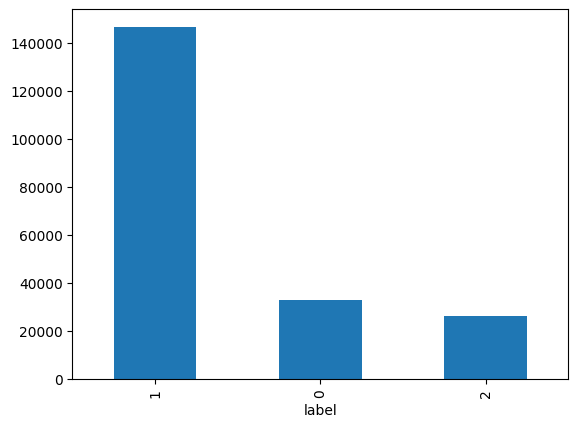

In [11]:


train_data['label'].value_counts().plot(kind = 'bar')

In [12]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label   count
0      0   32672
1      1  146624
2      2   26204


In [13]:
# 한글과 공백을 제외하고 모두 제거
train_data['리뷰'] = train_data['리뷰'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['리뷰'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

상품분류          0
브랜드명          0
상품명           0
사용자 이름        0
별점            0
리뷰작성날짜        0
나이            0
성별            0
피부타입      43829
피부트러블     44539
리뷰            0
label         0
dtype: int64


In [14]:
test_data.drop_duplicates(subset = ['리뷰'], inplace=True) # 중복 제거
test_data['리뷰'] = test_data['리뷰'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['리뷰'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 43063


In [15]:
from eunjeon import Mecab

mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [16]:
train_data['tokenized'] = train_data['리뷰'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [17]:
test_data['tokenized'] = test_data['리뷰'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [18]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
neutral_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 2]['tokenized'].values)


In [19]:
from collections import Counter

# 문장 부호 및 특수 문자 리스트
stop_words = ['.', ',', '!', '?']

# 문장 부호/특수 문자 제거
filtered_words = [word for word in positive_words if word not in stop_words]

# 빈도수 계산
positive_word_count = Counter(filtered_words)

# 가장 빈번하게 등장하는 단어 20개 출력
print(positive_word_count.most_common(20))


[('좋', 20974), ('있', 15802), ('사용', 14891), ('어요', 14482), ('같', 14464), ('네요', 13157), ('아요', 12961), ('는데', 12508), ('구매', 11445), ('것', 10325), ('잘', 10250), ('제품', 10136), ('했', 9990), ('습니다', 9719), ('않', 8837), ('되', 8511), ('해', 8003), ('기', 7791), ('해서', 7544), ('보', 7461)]


긍정 리뷰의 평균 길이 : 49.07665184417285
중립 리뷰의 평균 길이 : 45.11002137078309
부정 리뷰의 평균 길이 : 50.830986777668954


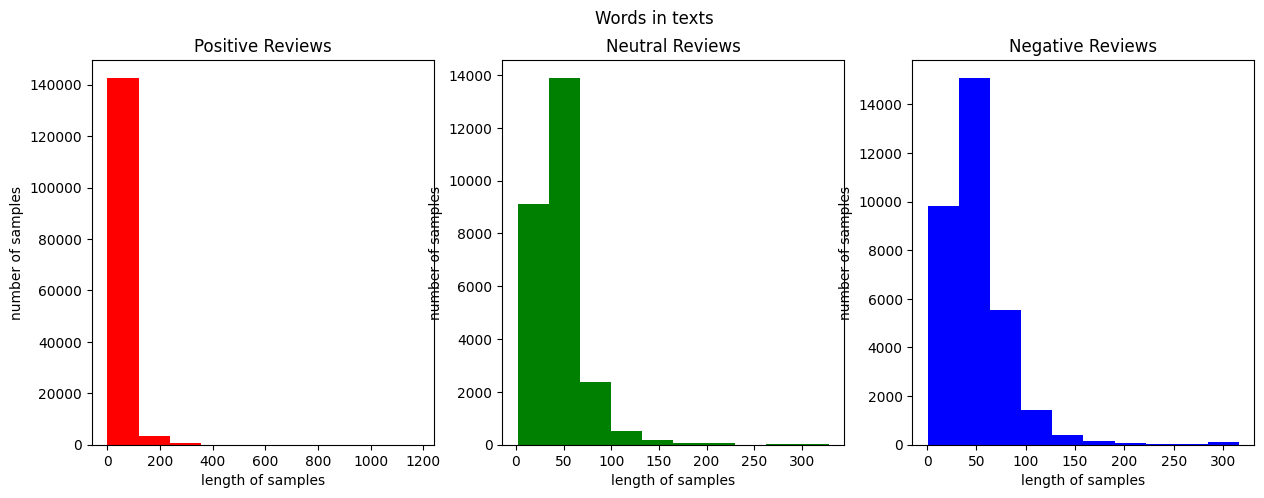

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# 긍정 리뷰
text_len = train_data[train_data['label'] == 1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

# 중립 리뷰
text_len = train_data[train_data['label'] == 2]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='green')
ax2.set_title('Neutral Reviews')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('중립 리뷰의 평균 길이 :', np.mean(text_len))

# 부정 리뷰
text_len = train_data[train_data['label'] == 0]['tokenized'].map(lambda x: len(x))
ax3.hist(text_len, color='blue')
ax3.set_title('Negative Reviews')
ax3.set_xlabel('length of samples')
ax3.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))

fig.suptitle('Words in texts')
plt.show()


In [21]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [22]:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [23]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 45603
등장 빈도가 1번 이하인 희귀 단어의 수: 18188
단어 집합에서 희귀 단어의 비율: 39.883341008266996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.181180137365385


In [24]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 27417


In [25]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [26]:
print(X_train[:3])

[[137, 64, 81, 308, 2456, 2084, 387, 71, 15355, 12, 70, 22394, 2456, 8548, 3894, 123, 449, 124, 42, 105, 357, 50, 1176, 542, 61, 286, 145, 620, 308, 426, 3, 99, 22, 176, 11, 45, 1213, 130, 305, 1075, 115, 105, 158, 888, 58, 108, 34, 522, 776, 1610, 741, 54, 1118, 105, 357, 50, 1176, 542, 61, 3, 6], [132, 333, 420, 346, 359, 37, 12, 40, 50, 4, 35, 3, 48, 15, 2, 1748, 1433, 138, 181, 146, 246, 622, 4, 4701, 243, 1997, 113, 3, 48, 15, 2531, 522, 1433, 83, 373, 38, 16, 38, 43, 24, 62, 571, 113, 43, 140, 2, 9751, 123, 2941, 38, 98, 45, 226, 15, 2], [3960, 963, 3198, 10, 157, 64, 14, 8, 596, 75, 31, 65, 384, 383, 16, 17, 9, 55, 189, 81, 48, 5, 278, 174, 13, 175, 16, 103, 35, 112, 52, 22, 524, 20, 131, 68, 374, 73, 13, 142, 54, 26, 31, 86, 12, 235, 20, 17, 9, 6]]


In [27]:
print(X_test[:3])

[[204, 9, 1711, 29, 4962, 18, 79, 40, 44, 7, 56, 1249, 79, 14, 82, 18, 64, 4273, 49, 56, 3, 6, 474, 138, 33, 26, 3, 566, 525, 152, 7, 31, 34, 141, 778, 44, 64, 12, 23, 137, 3, 126, 5, 378, 10, 1061, 7, 40, 11, 347], [206, 267, 153, 605, 63, 1141, 206, 4129, 27, 27, 311, 261, 43, 238, 1, 316, 43, 2551, 8, 29, 13, 9988, 5, 27, 519, 218, 805, 69, 5566, 51, 1409, 13, 84, 218, 34, 203, 2, 145, 3, 11, 121], [533, 194, 1690, 187, 1026, 934, 202, 3770, 13, 308, 5126, 14, 5, 2, 132, 522, 130, 3161, 5, 2, 338, 801, 132, 62, 1426, 420, 5, 2, 2498, 4856, 1172, 316, 333, 350, 344, 53, 448, 2034, 386, 2034, 181, 2034, 2029, 486, 359, 316, 1500, 20469, 3605, 8023, 675, 279, 1196, 18, 211, 3392, 832, 96, 153, 127, 3085, 2, 592, 34, 512, 7, 22, 3, 6, 2, 159, 4921, 34, 367, 4371, 2, 418, 328, 3, 6, 2, 7, 77, 153, 3, 6, 2]]


리뷰의 최대 길이 : 1181
리뷰의 평균 길이 : 48.84977128953771


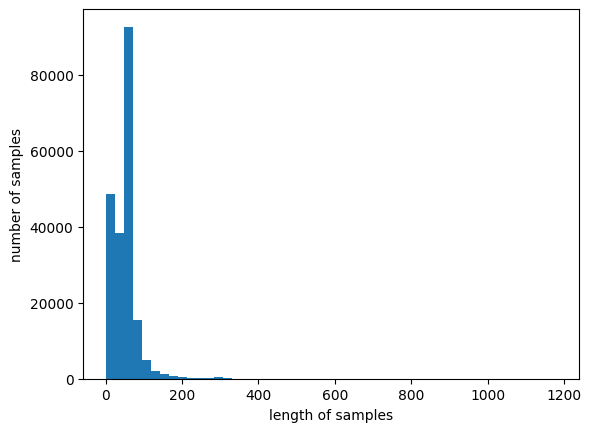

In [28]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [29]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))


max_len = 100
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 100 이하인 샘플의 비율: 95.75425790754258


In [30]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [31]:
2 in y_train

True

In [33]:
from keras.layers import Embedding, Dense, GRU
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.metrics import Precision, Recall
from keras import backend as K

def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall) / (precision+recall+K.epsilon())
    return f1_val


embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(3, activation='softmax'))  # 클래스가 3개라서 뉴런 수를 3으로, 활성화 함수를 softmax로 설정

es = EarlyStopping(monitor='val_f1_m', mode='max', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_f1_m', mode='max', verbose=1, save_best_only=True)


# 모델 컴파일
model.compile(optimizer='rmsprop', 
              loss='sparse_categorical_crossentropy', 
              metrics=['acc', f1_score])


# 모델 학습
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)



Epoch 1/15
2569/2569 [==============================] - ETA: 0s - loss: 0.4450 - acc: 0.8345 - f1_m: 0.9921
Epoch 1: val_f1_m improved from -inf to 0.98330, saving model to best_model.h5
2569/2569 [==============================] - 266s 103ms/step - loss: 0.4450 - acc: 0.8345 - f1_m: 0.9921 - val_loss: 0.3415 - val_acc: 0.8733 - val_f1_m: 0.9833
Epoch 2/15


c:\Users\selah\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2569/2569 [==============================] - ETA: 0s - loss: 0.2973 - acc: 0.8884 - f1_m: 0.9842
Epoch 2: val_f1_m did not improve from 0.98330
2569/2569 [==============================] - 254s 99ms/step - loss: 0.2973 - acc: 0.8884 - f1_m: 0.9842 - val_loss: 0.2741 - val_acc: 0.8984 - val_f1_m: 0.9758
Epoch 3/15
2569/2569 [==============================] - ETA: 0s - loss: 0.2349 - acc: 0.9123 - f1_m: 0.9712
Epoch 3: val_f1_m did not improve from 0.98330
2569/2569 [==============================] - 275s 107ms/step - loss: 0.2349 - acc: 0.9123 - f1_m: 0.9712 - val_loss: 0.2301 - val_acc: 0.9141 - val_f1_m: 0.9592
Epoch 4/15
2569/2569 [==============================] - ETA: 0s - loss: 0.1922 - acc: 0.9303 - f1_m: 0.9569
Epoch 4: val_f1_m did not improve from 0.98330
2569/2569 [==============================] - 291s 113ms/step - loss: 0.1922 - acc: 0.9303 - f1_m: 0.9569 - val_loss: 0.2045 - val_acc: 0.9263 - val_f1_m: 0.9576
Epoch 5/15
2569/2569 [==============================] - ETA: 0s 

In [34]:
test_score = model.evaluate(X_test, y_test)
print("테스트 정확도: %.4f" % test_score[1])

1346/1346 [==============================] - 13s 10ms/step - loss: 0.1639 - acc: 0.9430 - f1_m: 1.0107
테스트 정확도: 0.9430


In [40]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)  # mecab이 이미 선언되어 있어야 함
  new_sentence = [word for word in new_sentence if not word in stopwords]  # stopwords가 이미 선언되어 있어야 함
  encoded = tokenizer.texts_to_sequences([new_sentence])  # tokenizer가 이미 선언되어 있어야 함
  pad_new = pad_sequences(encoded, maxlen=max_len)  # max_len이 이미 선언되어 있어야 함
  
  scores = model.predict(pad_new)  # 모델이 메모리에 로드되어 있어야 함
  print(scores)  # 디버깅용
  
  predicted_class = np.argmax(scores)  # 가장 확률이 높은 클래스를 선택
  
  if predicted_class == 0:
    print("긍정 리뷰입니다.")
  elif predicted_class == 1:
    print("중립 리뷰입니다.")
  else:
    print("부정 리뷰입니다.")

    
sentiment_predict('최악이에요')

1/1 [==============================] - 0s 19ms/step
[[9.6245700e-01 3.6724068e-02 8.1888377e-04]]
긍정 리뷰입니다.
